In [1]:
import time, os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from datetime import datetime

In [2]:
def plot_vs(x, ys, errors, title):
    fig=plt.figure(figsize=(10, 8))
    Y = ys[0]
    for y in ys:
        plt.plot(X, y[0], label=y[1])

    for y in ys[1:]:
        plt.plot(X, np.abs(Y[0] - y[0]), label='Error %s vs %s' % (Y[1], y[1]), color='crimson')
    plt.xlabel(title)
    plt.axhline(y=0, color='k', linestyle=':', linewidth=1)
    plt.axvline(x=0, color='k', linestyle=':', linewidth=1)
    plt.legend()

def plot(x, y, title):
    fig = plt.figure(figsize=(10,8))
    plt.plot(x, y)
    plt.xlabel(title)
    plt.axhline(y=0, color='k', linestyle=':', linewidth=1)
    plt.axvline(x=0, color='k', linestyle=':', linewidth=1)
    plt.legend()
    
def showplots(f,approxlist,a,b):
    x = np.linspace(a,b,1000)
    plt.figure(1, figsize=(10, 8))
    plt.subplot(211)
    
    vfuncs = [np.vectorize(approx) for approx in approxlist]
    for i, vf in enumerate(vfuncs):
        plt.plot(x,vf(x), label='Approximation %d' % (i))
    plt.plot(x,f(x), label='Original')
    plt.xlim(a,b)
    plt.ylabel('f(x) and approximations fa(x)')

    plt.axhline(y=0, color='k', linestyle=':', linewidth=1)
    plt.axvline(x=0, color='k', linestyle=':', linewidth=1)
    plt.legend()
    plt.subplot(212)
    for i, vf in enumerate(vfuncs):
        plt.plot(x,f(x)-vf(x), label='Approx. %d' % (i))
    plt.xlim(a,b)
    plt.ylabel('error = f(x)-fa(x)')
    plt.xlabel('x')
    plt.axhline(y=0, color='k', linestyle=':', linewidth=1)
    plt.axvline(x=0, color='k', linestyle=':', linewidth=1)
    plt.legend()
    plt.show()

Chebishev Polynomials are based on $T_n(x)$, in this case, the formula to compute each range is the following:
\begin{equation*}
T_0(x) = 1 \\
T_1(x) = x \\
T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x)
\end{equation*}

There is also this formula:
\begin{equation*}
T_n(x) = cos(n * cos^{-1}(x)) = cos(n * arccos(x))
\end{equation*}

In [3]:
def chebyshev_t(x, degree):
    if degree == 0:
        return np.ones(x.shape)
    elif degree == 1:
        return x
    else:
        return 2 * x * chebyshev_t(x, degree-1) - chebyshev_t(x, degree - 2)


If we are given $f(x)$ defined over the range $ x \in [a, b]$, we can express:

\begin{equation*}
f(x) = \sum{c_k*T_k(u)}
\end{equation*}


We need to map $x$ to $u$. In that way, we achieve moving from $x \in [a, b]$ to $u \in [-1, 1]$.

Where:

\begin{equation*}
u = \dfrac{2x - a - b}{b - a}
\end{equation*}

and:

\begin{equation*}
x = \dfrac{b-a}{2}u + \dfrac{a + b}{2}
\end{equation*}

In [4]:
def to_x(u, a, b):
    return ((b - a)/2) * u + ((a + b)/2)

def to_u(x, a, b):
    return (2 * x - a - b) / (b - a)

def chebyshev_approx(C, x, a, b):
    u = to_u(x, a, b)
    fx = c[0] + c[1] * u
    for degree, c in enumerate(C[2:]):
        fx += c * chebishev_t(u, degree + 2)


The chebishev nodes are calculated according to the following formula:

\begin{equation*}
x_i = cos \left( \dfrac{2i - 1}{2n} * \pi \right) = cos \left( \dfrac{i - 0.5}{n} * \pi \right), i=1, ..., n
\end{equation*}

In [5]:
def chebspace(N):
    t = (np.array(range(0, N)) + 0.5) / N
    return -np.cos(t * np.math.pi)
print(chebspace(5))
to_x(chebspace(5), -1, 3.0)

[-9.51056516e-01 -5.87785252e-01 -6.12323400e-17  5.87785252e-01
  9.51056516e-01]


array([-0.90211303, -0.1755705 ,  1.        ,  2.1755705 ,  2.90211303])

In [6]:
def chebyshev_nodes(N):
    i = np.array(range(1 , N+ 1))
    t = ((2 * i) - 1) / (2 * N)
    x = -np.cos(t * np.math.pi)
    return np.round(x, 6)

chebyshev_nodes(5)


array([-0.951057, -0.587785, -0.      ,  0.587785,  0.951057])

To approxiamte a function a by a linear combination of the first $N$Chebyshev polynomials (from $k = 0$ to $k = N - 1$), the coefficient $c_k$ is equal to $A(k)$ times the average of the products of $T_k(u)f(x)$ where:
\begin{equation}
    A(k) =
\left\{
    \begin{array}{ll}
        1  &  k = 0 \\
        2 &  k \ne 0
    \end{array}
\right.
\label{eq:coincidence_score_matrix2}
\end{equation}

In summary, the formula to compute $c_0$ and its generalization to $c_n$ is the following:

\begin{equation}
\overrightarrow{u} = cos \left( \dfrac{2i - 1}{2n} * \pi \right) \forall i \in [1, n] \\
\overrightarrow{x} = \dfrac{b-a}{2}\overrightarrow{u} + \dfrac{a + b}{2}\\
c_0 = \dfrac{A(0) * T_0(\overrightarrow{u}) \times f(\overrightarrow{x})}{N} = \dfrac{1 * T_0(\overrightarrow{u}) \times f(\overrightarrow{x})}{N} \\
c_1 = \dfrac{A(1) * T_1(\overrightarrow{u}) \times f(\overrightarrow{x})}{N} = \dfrac{2 * T_1(\overrightarrow{u}) \times f(\overrightarrow{x})}{N} \\
... \\
c_n =  \dfrac{A(n) * T_n(\overrightarrow{u}) \times f(\overrightarrow{x})}{N}
\end{equation}

In [7]:
def chebyshev_a(k):
    return 1 if k == 0 else 2
chebyshev_a(0), chebyshev_a(1), chebyshev_a(2), chebyshev_a(3)

(1, 2, 2, 2)

No handles with labels found to put in legend.


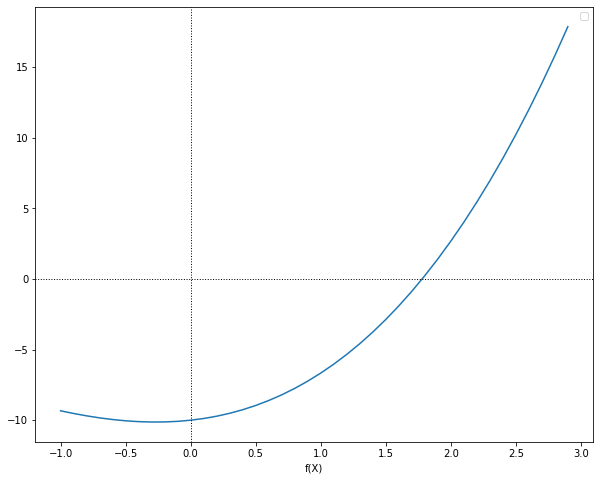

In [8]:
f = lambda x: np.round(((1/3) * (x ** 3)) + (2 * (x ** 2)) + x - 10, 6)
x = np.arange(-1, 3, 10**-1)
plot(x, f(x), 'f(X)')

In [9]:
a = -1
b = 3
u = chebyshev_nodes(5)
x = to_x(u, a, b)
print("Approximating f(x) with x in range [%d, %d]" % (a, b))
print(u, x)

Approximating f(x) with x in range [-1, 3]
[-0.951057 -0.587785 -0.        0.587785  0.951057] [-0.902114 -0.17557   1.        2.17557   2.902114]


In [10]:
y = f(x)
y

array([ -9.519211, -10.115724,  -6.666667,   5.07418 ,  17.894104])

In [11]:
c_0 = chebyshev_a(0) * y.sum() / 5
c_0 = np.round(c_0, 6)
c_0

-0.666664

In [12]:
c_1 = chebyshev_a(1) * (y.dot(u)) / 5
c_1

14.000009138638001

In [13]:
c_2 = chebyshev_a(2) * (y.dot(chebyshev_t(u, 2))) / 5
c_2

6.000015575325054

In [14]:
c_3 = chebyshev_a(3) * (y.dot(chebyshev_t(u, 3))) / 5
c_3

0.666713938412979

In [15]:
def calculate_c(u, n, N):
    return chebyshev_a(n) * (y.dot(chebyshev_t(u, n))) / N

def chebyshev_c(f, N, a, b):
    c = []
    u = chebyshev_nodes(N)
    x = to_x(u, a, b)
    y = f(x)
    for i in range(N):
        c.append(calculate_c(u, i, N))
    return np.round(c, 4)
chebyshev_c(f, 5, -1, 3)

array([-0.6667, 14.    ,  6.    ,  0.6667,  0.    ])

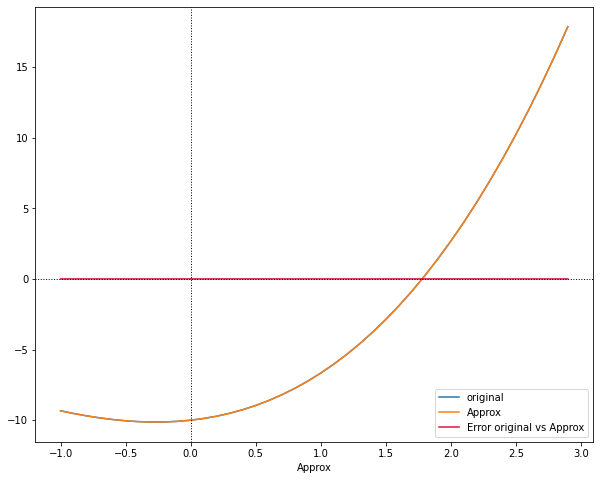

In [18]:
class ChebyshevPolynomial(object):
    def __init__(self, name='ChebyshevPolynomial'):
        self.__name__ = name
    
    def to_x(self, u, a, b):
        return ((b - a)/2) * u + ((a + b)/2)

    def to_u(self,x, a, b):
        return np.array((2 * x - a - b) / (b - a))
    
    def chebyshev_t(self, x, degree):
        if degree == 0:
            return np.ones(x.shape)
        elif degree == 1:
            return x
        else:
            return 2 * x * self.chebyshev_t(x, degree-1) - self.chebyshev_t(x, degree - 2)
        
    def chebyshev_nodes(self, N):
        t = (np.array(range(0, N)) + 0.5) / N
        return -np.cos(t * np.math.pi)
    
    def chebyshev_a(self, k):
        return 1 if k == 0 else 2
    
    def calculate_c(self, y, u, n, N):
        return self.chebyshev_a(n) * (y.dot(self.chebyshev_t(u, n))) / N

    def chebyshev_c(self, f, N, a, b):
        c = []
        u = self.chebyshev_nodes(N)
        x = self.to_x(u, a, b)
        y = f(x)
        for i in range(N):
            c.append(self.calculate_c(y, u, i, N))
        return np.round(c, 4)

    def fit(self, f, N, a, b):
        self.a = a
        self.b = b
        self.N = N
        self.C = self.chebyshev_c(f, N, a, b)
        return self 
    
    def predict_single(self, x):
        np.array((2 * x - self.a - self.b) / (self.b - self.a))
    def __call__(self, x):
        return self.predict(x)
    
    def as_function(self):
        if self.C is None:
            raise Exception
        def f(x):
            return self.predict(x)
        f = lambda x: self.predict(x)
        
        return f
    
    def __repr__(self):
        return "Cheby%s" % ((self.a, self.b)+tuple(c for c in self.C)).__repr__()
    
    def __str__(self):
        return r"$$f(x) =" + " ".join(["%+0.2f * T_%d(u)"%(c, i) for i, c in enumerate(self.C)]) + "$$"
        
    
    def eq(self):
        from IPython.display import display, Math, Latex
        display(Math(self.__str__()))
        
    def predict(self, x):
        # if self.C is None:http://127.0.0.1:10093/notebooks/mnt_dir/models/quickdraw/discriminator/AppleDiscriminator.ipynb#
        #    raise Exception
        
        u = self.to_u(x, self.a, self.b)
        y = np.zeros(u.shape)
        for degree, c in enumerate(self.C):
            ch = self.chebyshev_t(u, degree)
            y += c * ch
        
        return y
cheby = ChebyshevPolynomial()
cheby = cheby.fit(f, 6, -1, 3)
X = np.arange(-1, 3, 10**-1)
Y = f(X)
Y_hat = cheby(X)
ys = [(Y, 'original'), (Y_hat, 'Approx')]
errors = [np.abs(Y - y[0]) for y in ys[1:]]
plot_vs(X, ys , errors, 'Approx')

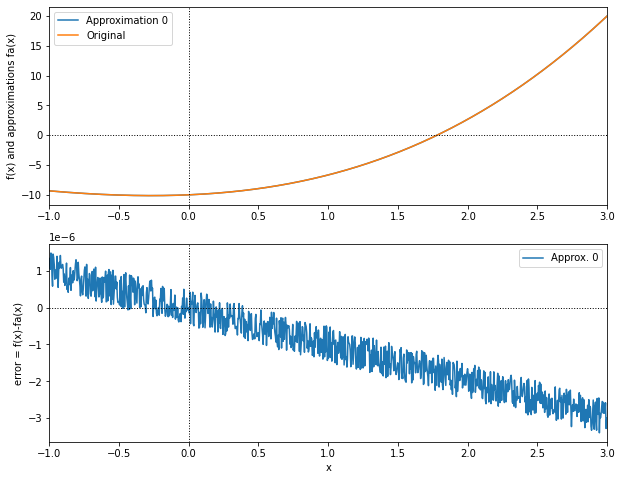

In [17]:
chebys = [ChebyshevPolynomial().fit(f, i, -100, 100) for i in [4]]
showplots(f,chebys,-1,3)